In [1]:
id_ = 'Zilionis_Klein_2019_NSCLC'
# id = 'Lambrechts_2018_LUAD_6149v1'
backup_dir = '/root/datos/maestria/netopaas/luca_explore/surgeries'
infercnv_dir = '/root/datos/maestria/netopaas/infercnv'
ikarus_dir = '/root/datos/maestria/netopaas/ikarus'
load_wilcoxon = True
load_gsea = True
load_gsea_heatmap = False
run_umap = False

In [2]:
# Parameters
id_ = "UKIM-V-2"


# Cell Type Verification

## Libraries and Data

We want to check our tumor vs normal classifier. For that we will explore the state of our cells by different methods.

1. Via UMAP, how the types of cell cluster vs the tumor and normal labels. Also, if it is normal adjacent or tumor. Sample labels to discard batch effects.
2. Marker genes plots for these comparisons per cell type: (**TypeNormalPred_HT** vs **REST**) (**TypeNormalPred_TT** vs **REST**) (**TypeNormalPred_HT** vs **TypeNormalPred_TT**)
   (**TypeTumorPred_TT** vs **REST**) (**TypeTumorPred_TT** vs **TypeNormalPred_TT**)
3. Heatmaps With the above groups (**TumorPred_TT**, **NormalPred_TT**, **NormalPred_HT**) as  cell labels and hierarchical clustering in the genes. With genes chosen from the marker genes.
4. Prevalent gene ontologies for each of the groups above, considering also hallmark ontologies

In [3]:
import os
from pathlib import Path
import gdown

import sys
# This makes the working dir change apparently
sys.path.append("..")
import utils.functions as ut

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
from scipy.sparse import csr_matrix

import anndata as ad
import scanpy as sc

In [4]:
# adata = sc.read_h5ad(f'{backup_dir}/combTumor_{id_}.h5ad')
adata = sc.read_h5ad(f'{backup_dir}/filtered_{id_}.h5ad')
adata

AnnData object with n_obs × n_vars = 127150 × 31048
    obs: 'patient', 'file_id', 'origin', 'sex', 'age', 'uicc_stage', 'condition', 'ever_smoker', 'sample', 'platform', 'platform_fine', 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito'
    var: 'n_counts', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Types from infercnv dir

In [5]:
types = pd.read_csv(f'{infercnv_dir}/{id_}.csv')
types = types.rename(columns={'Unnamed: 0':'barcode_'})
types = types.rename(columns={'Level_2_transfered_label':'cell_type'})
types

,barcode_,cell_type
0,50478_0,Myeloid
1,240865_0,Myeloid
2,333891_0,Myeloid
3,710927_0,Myeloid
4,769941_0,Myeloid
...,...,...
127145,811511_27,Myeloid
127146,468397_27,Myeloid
127147,115884_27,Myeloid
127148,201201_27,Myeloid


In [6]:
adata.obs['barcode_'] = adata.obs.index
adata.obs = pd.merge(adata.obs, types, on='barcode_',
                    how='left')
adata.obs.cell_type = adata.obs.cell_type.fillna('Unknown')
adata.obs.columns

Index(['patient', 'file_id', 'origin', 'sex', 'age', 'uicc_stage', 'condition',
       'ever_smoker', 'sample', 'platform', 'platform_fine', 'n_counts',
       'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mito',
       'pct_counts_mito', 'barcode_', 'cell_type'],
      dtype='object')

### Tumor prediction from ikarus

In [7]:
preds = pd.read_csv(f'{ikarus_dir}/{id_}.csv')
preds

,Unnamed: 0,final_pred
0,0,Tumor
1,1,Tumor
2,2,Tumor
3,3,Tumor
4,4,Tumor
...,...,...
127145,127145,Normal
127146,127146,Normal
127147,127147,Tumor
127148,127148,Normal


In [8]:
adata.obs['final_pred'] = list(preds.iloc[:,1])

In [9]:
adata.obs['origin']

0         normal_adjacent
1         normal_adjacent
2         normal_adjacent
3         normal_adjacent
4         normal_adjacent
               ...       
127145      tumor_primary
127146      tumor_primary
127147      tumor_primary
127148      tumor_primary
127149      tumor_primary
Name: origin, Length: 127150, dtype: category
Categories (2, object): ['normal_adjacent', 'tumor_primary']

In [10]:
adata[np.logical_or(adata.obs['origin'].str.contains('normal'), adata.obs['origin']=='tumor_primary')].obs['origin'].value_counts()

origin
tumor_primary      67813
normal_adjacent    59337
Name: count, dtype: int64

In [11]:
adata.layers['counts'] = adata.X

In [12]:
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

## UMAP Clusters

We see similarities between cell types in normal tisse and tumor tissue. And  also what cell types are tumoral.

In [13]:
#papermill_description=UMAP
if run_umap:
    sc.tl.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)

In [14]:
if run_umap:
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    
    sc.pl.umap(
        adata,
        color="cell_type",
        # legend_loc="on data",
        legend_fontoutline=2,
        ax=axs[0, 0],  # Specifies the subplot
        show=False  # Prevents showing the plot immediately
    )
    
    sc.pl.umap(
        adata,
        color="final_pred",
        # legend_loc="on data",
        legend_fontoutline=2,
        ax=axs[0, 1],  # Specifies the subplot
        show=False  # Prevents showing the plot immediately
    )
    
    sc.pl.umap(
        adata,
        color="origin",
        # legend_loc="on data",
        legend_fontoutline=2,
        ax=axs[1, 0],  # Specifies the subplot
        show=False  # Prevents showing the plot immediately
    )
    
    sc.pl.umap(
        adata,
        color="sample",
        # legend_loc="on data",
        legend_fontoutline=2,
        ax=axs[1, 1],  # Specifies the subplot
        show=False  # Prevents showing the plot immediately
    )
    
    # Display the entire figure with all plots
    plt.tight_layout()
    plt.show()

We can see that for the 'Tumor' prediciton there are mostly cells from patient 41, although there are many more samples from primary tumor.
This could be due to batch effects. So it is worthwile to run the prediction again with batch correction.

In [15]:
# adata.obs.groupby('leiden').count()
adata.obs.groupby('sample').count().iloc[:,0]

/tmp/ipykernel_27790/2910804369.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('sample').count().iloc[:,0]


sample
P4_normal_adjacent      2579
P4_tumor_primary        2089
P5_normal_adjacent      3665
P5_tumor_primary        2481
P6_normal_adjacent      4947
P6_tumor_primary        6386
P7_normal_adjacent      4560
P7_tumor_primary        2876
P8_normal_adjacent      3166
P8_tumor_primary         973
P9_normal_adjacent      3556
P9_tumor_primary        6228
P10_normal_adjacent    10866
P10_tumor_primary       8038
P11_normal_adjacent     4840
P11_tumor_primary       5613
P12_normal_adjacent     2808
P12_tumor_primary       7294
P13_normal_adjacent     2921
P13_tumor_primary       7091
P14_normal_adjacent     4667
P14_tumor_primary       6763
P15_normal_adjacent     4032
P15_tumor_primary       3924
P16_normal_adjacent     4551
P16_tumor_primary       4263
P17_normal_adjacent     2179
P17_tumor_primary       3794
Name: patient, dtype: int64

## Marker Genes

Create a column that merges cell type, tissue and tumor pred

In [16]:
adata.obs['type_tissue'] = adata.obs.apply(lambda x: str(x['cell_type']) + '_' + 
                 ('HT' if 'normal' in x['origin'] else 'TT') + 
                 '_' + x['final_pred'], axis=1)
adata.obs['type_tissue'] = adata.obs['type_tissue'].astype('category')
adata.obs['type_tissue']

0          Myeloid_HT_Tumor
1          Myeloid_HT_Tumor
2          Myeloid_HT_Tumor
3          Myeloid_HT_Tumor
4          Myeloid_HT_Tumor
                ...        
127145    Myeloid_TT_Normal
127146    Myeloid_TT_Normal
127147     Myeloid_TT_Tumor
127148    Myeloid_TT_Normal
127149    Myeloid_TT_Normal
Name: type_tissue, Length: 127150, dtype: category
Categories (33, object): ['Airway epithelium_HT_Normal', 'Airway epithelium_HT_Tumor', 'Airway epithelium_TT_Normal', 'Airway epithelium_TT_Tumor', ..., 'Unknown_HT_Normal', 'Unknown_HT_Tumor', 'Unknown_TT_Normal', 'Unknown_TT_Tumor']

In [17]:
# We dont get them with unique because it saves the NaN's
adata.obs.cell_type = adata.obs.cell_type.astype('category')
types = adata.obs.cell_type.cat.categories
num_types = len(types)
types

Index(['Airway epithelium', 'Alveolar epithelium', 'Blood vessels',
       'Fibroblast lineage', 'Lymphatic EC', 'Lymphoid', 'Mesothelium',
       'Myeloid', 'Smooth muscle', 'Unknown'],
      dtype='object')

In [18]:
adata.obs['type_tissue'].value_counts()

type_tissue
Lymphoid_TT_Normal               36209
Lymphoid_HT_Normal               24945
Myeloid_HT_Tumor                 24358
Myeloid_TT_Tumor                 14097
Myeloid_TT_Normal                 8817
Myeloid_HT_Normal                 7017
Unknown_TT_Normal                 3310
Alveolar epithelium_TT_Normal     2038
Airway epithelium_TT_Normal       1712
Airway epithelium_HT_Normal       1116
Airway epithelium_TT_Tumor         718
Unknown_HT_Normal                  627
Alveolar epithelium_HT_Normal      598
Blood vessels_HT_Normal            378
Unknown_TT_Tumor                   248
Alveolar epithelium_TT_Tumor       240
Fibroblast lineage_TT_Normal       185
Blood vessels_TT_Normal            153
Fibroblast lineage_HT_Normal        73
Lymphatic EC_HT_Normal              68
Mesothelium_HT_Normal               59
Lymphoid_TT_Tumor                   41
Airway epithelium_HT_Tumor          32
Unknown_HT_Tumor                    29
Mesothelium_TT_Normal               19
Smooth muscle

In [19]:
#papermill_description=WILCOXON_DE
# Get the groups that have more than 2 cells associated with them
valid_types = list(adata.obs['type_tissue'].value_counts().loc[lambda x: x > 2].index)
w_folder = 'wilcoxon_DE'

# Load

all_path = f'{w_folder}/all_{id_}.npy'
key = "wilcoxon"

if load_wilcoxon:
    adata.uns[key] = np.load(all_path, allow_pickle='TRUE').item()
else:
    sc.tl.rank_genes_groups(adata, 'type_tissue', method='wilcoxon', key_added = key,
                       groups=valid_types)
    np.save(all_path, adata.uns[key])

for type in types:
    tumor_tumor = type + '_TT_Tumor'
    normal_tumor = type + '_TT_Normal'
    normal_healthy = type + '_HT_Normal'

    differ_key = f"w_pair_{type}_differ"
    normal_key = f"w_pair_{type}_normal"
    differ_path =  f'{w_folder}/{differ_key}.npy'
    normal_path = f'{w_folder}/{normal_key}.npy'
    if load_wilcoxon:
        # We check for existance  here and not up there because there some datasets with no normal tissue
        if os.path.exists(differ_path):
            adata.uns[differ_key] = np.load(differ_path, allow_pickle='TRUE').item()
        if os.path.exists(normal_path):
            adata.uns[normal_key] = np.load(normal_path, allow_pickle='TRUE').item()
    else:
        if set([tumor_tumor, normal_tumor]).issubset(valid_types):
            sc.tl.rank_genes_groups(adata, 'type_tissue', method='wilcoxon', key_added = differ_key,
                                    groups=[tumor_tumor], reference=normal_tumor)
            np.save(differ_path, adata.uns[differ_key])
            
        if set([normal_tumor, normal_healthy]).issubset(valid_types):
            sc.tl.rank_genes_groups(adata, 'type_tissue', method='wilcoxon', key_added = normal_key,
                                    groups=[normal_tumor], reference=normal_healthy)
            np.save(normal_path, adata.uns[normal_key])

In [20]:
def cond_plot(adata, cond_types, valid_types, ax=None,
              key='wilcoxon', fontsize=9, titlesize=14, **kwds):
    print(cond_types)
    if set(cond_types).issubset(valid_types):
        ut.rank_genes_group(adata, cond_types[0], n_genes=n_genes,
                            ax=ax, sharey=False, key=key, show=False,
                            fontsize=fontsize, titlesize=titlesize)
    else:
        # Draw an empty plot with a message
        ax.text(0.5, 0.5, f'Missing cells: {cond_types}', color='red', 
                       ha='center', va='center', transform=ax.transAxes)
        ax.axis('off')

In [21]:
valid_types

['Lymphoid_TT_Normal',
 'Lymphoid_HT_Normal',
 'Myeloid_HT_Tumor',
 'Myeloid_TT_Tumor',
 'Myeloid_TT_Normal',
 'Myeloid_HT_Normal',
 'Unknown_TT_Normal',
 'Alveolar epithelium_TT_Normal',
 'Airway epithelium_TT_Normal',
 'Airway epithelium_HT_Normal',
 'Airway epithelium_TT_Tumor',
 'Unknown_HT_Normal',
 'Alveolar epithelium_HT_Normal',
 'Blood vessels_HT_Normal',
 'Unknown_TT_Tumor',
 'Alveolar epithelium_TT_Tumor',
 'Fibroblast lineage_TT_Normal',
 'Blood vessels_TT_Normal',
 'Fibroblast lineage_HT_Normal',
 'Lymphatic EC_HT_Normal',
 'Mesothelium_HT_Normal',
 'Lymphoid_TT_Tumor',
 'Airway epithelium_HT_Tumor',
 'Unknown_HT_Tumor',
 'Mesothelium_TT_Normal',
 'Smooth muscle_HT_Normal',
 'Lymphatic EC_TT_Normal',
 'Smooth muscle_TT_Normal',
 'Alveolar epithelium_HT_Tumor',
 'Lymphoid_HT_Tumor']

['Airway epithelium_TT_Tumor']
['Airway epithelium_TT_Tumor', 'Airway epithelium_TT_Normal']
['Alveolar epithelium_TT_Tumor']
['Alveolar epithelium_TT_Tumor', 'Alveolar epithelium_TT_Normal']
['Blood vessels_TT_Tumor']
['Blood vessels_TT_Tumor', 'Blood vessels_TT_Normal']
['Fibroblast lineage_TT_Tumor']
['Fibroblast lineage_TT_Tumor', 'Fibroblast lineage_TT_Normal']
['Lymphatic EC_TT_Tumor']
['Lymphatic EC_TT_Tumor', 'Lymphatic EC_TT_Normal']
['Lymphoid_TT_Tumor']
['Lymphoid_TT_Tumor', 'Lymphoid_TT_Normal']
['Mesothelium_TT_Tumor']
['Mesothelium_TT_Tumor', 'Mesothelium_TT_Normal']
['Myeloid_TT_Tumor']
['Myeloid_TT_Tumor', 'Myeloid_TT_Normal']
['Smooth muscle_TT_Tumor']
['Smooth muscle_TT_Tumor', 'Smooth muscle_TT_Normal']
['Unknown_TT_Tumor']
['Unknown_TT_Tumor', 'Unknown_TT_Normal']


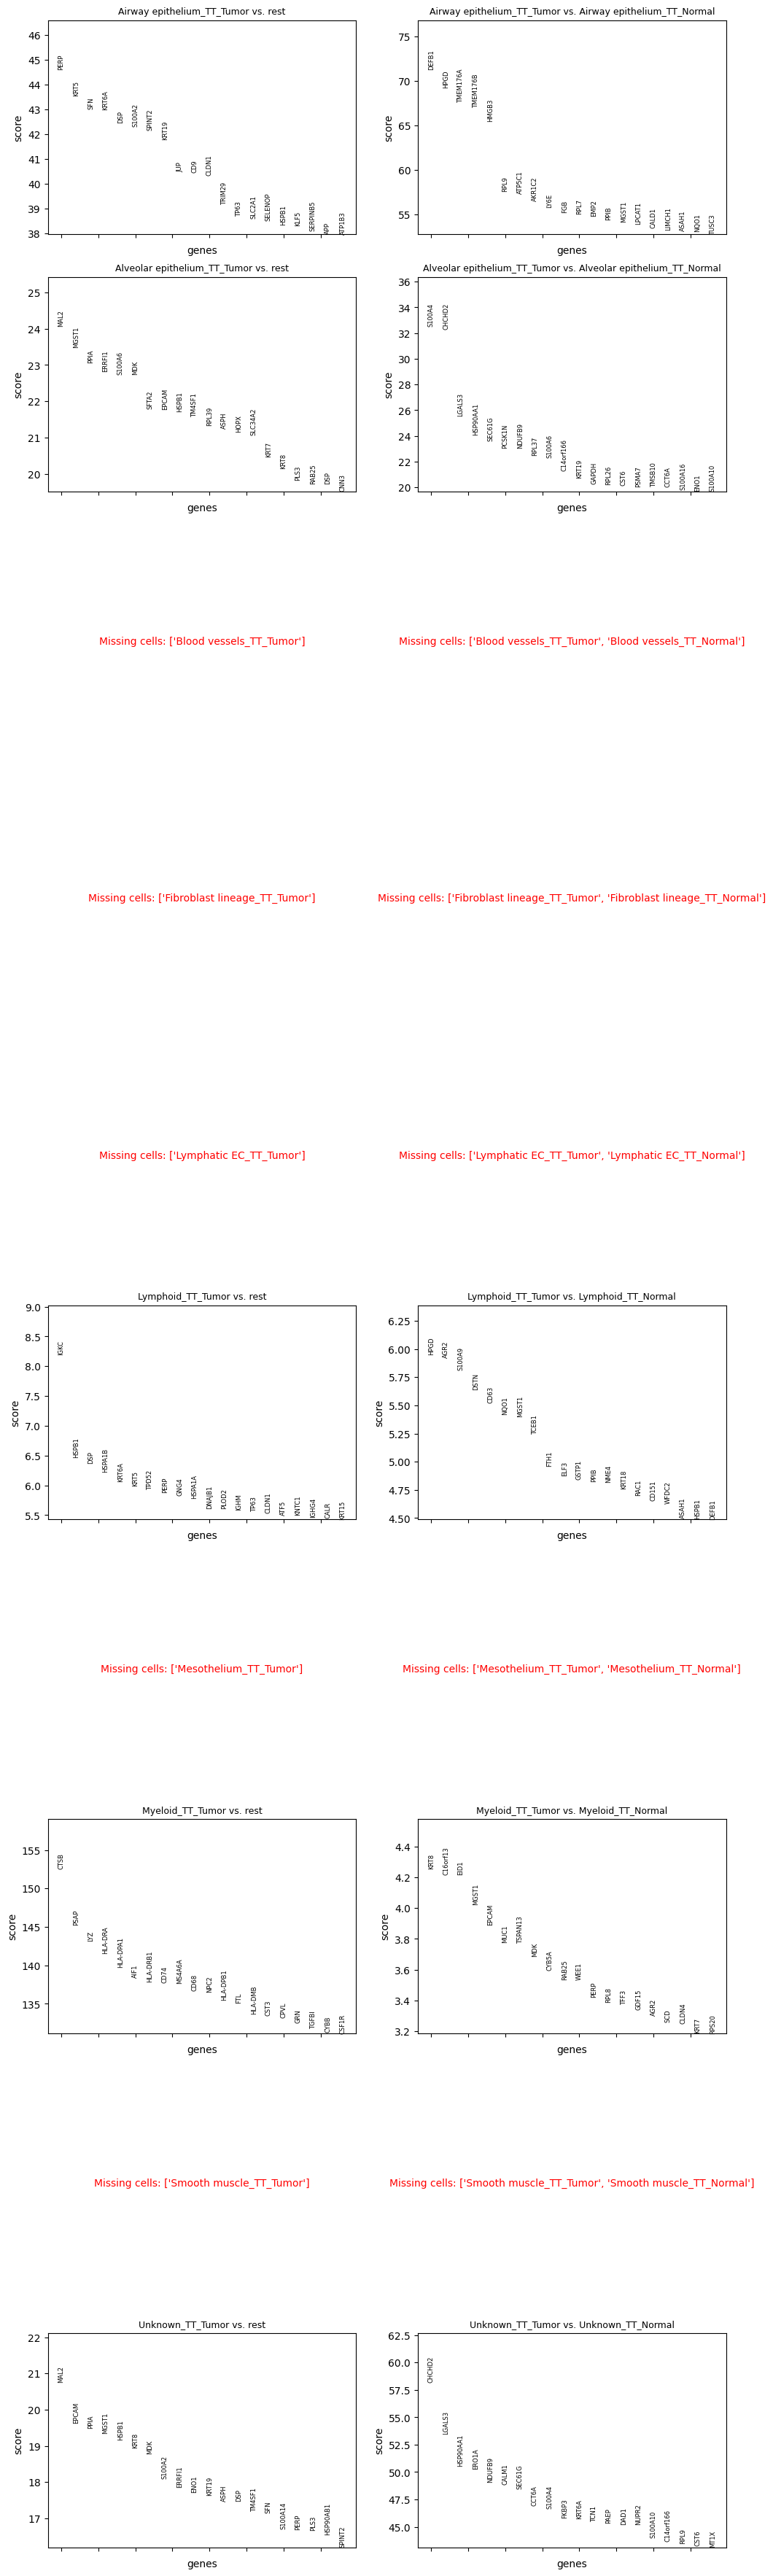

In [22]:
if(adata.obs.origin.str.contains('tumor').any()):
    fig, axs = plt.subplots(num_types, 2, figsize=(12, 4.5*num_types))
    n_genes = 20
    for i, type in enumerate(types):
        tumor_tumor = type + '_TT_Tumor'
        normal_tumor = type + '_TT_Normal'
        titlesize = 9
        fontsize = 6
    
        
        cond_plot(adata, [tumor_tumor], valid_types, n_genes=n_genes,
                         ax= axs[i, 0], sharey=False, key="wilcoxon", show=False,
                         fontsize=fontsize, titlesize=titlesize)
        cond_plot(adata, [tumor_tumor, normal_tumor], valid_types, n_genes=n_genes, ax= axs[i, 1],
                                key=f"w_pair_{type}_differ", show=False,
                         fontsize=fontsize, titlesize=titlesize)
    
    # Display the entire figure with all plots
    plt.show()
else:
    from warnings import warn
    warn('NO TUMOR TISSUES!?!?!?!!?')

In [23]:
adata.obs.origin.str.contains('normal').any()

True

['Airway epithelium_HT_Normal']
['Airway epithelium_TT_Normal']
w_pair_Airway epithelium_normal
['Airway epithelium_TT_Normal', 'Airway epithelium_HT_Normal']
['Alveolar epithelium_HT_Normal']


['Alveolar epithelium_TT_Normal']
w_pair_Alveolar epithelium_normal
['Alveolar epithelium_TT_Normal', 'Alveolar epithelium_HT_Normal']
['Blood vessels_HT_Normal']
['Blood vessels_TT_Normal']


w_pair_Blood vessels_normal
['Blood vessels_TT_Normal', 'Blood vessels_HT_Normal']
['Fibroblast lineage_HT_Normal']
['Fibroblast lineage_TT_Normal']
w_pair_Fibroblast lineage_normal
['Fibroblast lineage_TT_Normal', 'Fibroblast lineage_HT_Normal']
['Lymphatic EC_HT_Normal']
['Lymphatic EC_TT_Normal']


w_pair_Lymphatic EC_normal
['Lymphatic EC_TT_Normal', 'Lymphatic EC_HT_Normal']


['Lymphoid_HT_Normal']
['Lymphoid_TT_Normal']
w_pair_Lymphoid_normal
['Lymphoid_TT_Normal', 'Lymphoid_HT_Normal']


['Mesothelium_HT_Normal']
['Mesothelium_TT_Normal']
w_pair_Mesothelium_normal
['Mesothelium_TT_Normal', 'Mesothelium_HT_Normal']
['Myeloid_HT_Normal']
['Myeloid_TT_Normal']
w_pair_Myeloid_normal
['Myeloid_TT_Normal', 'Myeloid_HT_Normal']
['Smooth muscle_HT_Normal']


['Smooth muscle_TT_Normal']
w_pair_Smooth muscle_normal
['Smooth muscle_TT_Normal', 'Smooth muscle_HT_Normal']
['Unknown_HT_Normal']


['Unknown_TT_Normal']
w_pair_Unknown_normal
['Unknown_TT_Normal', 'Unknown_HT_Normal']


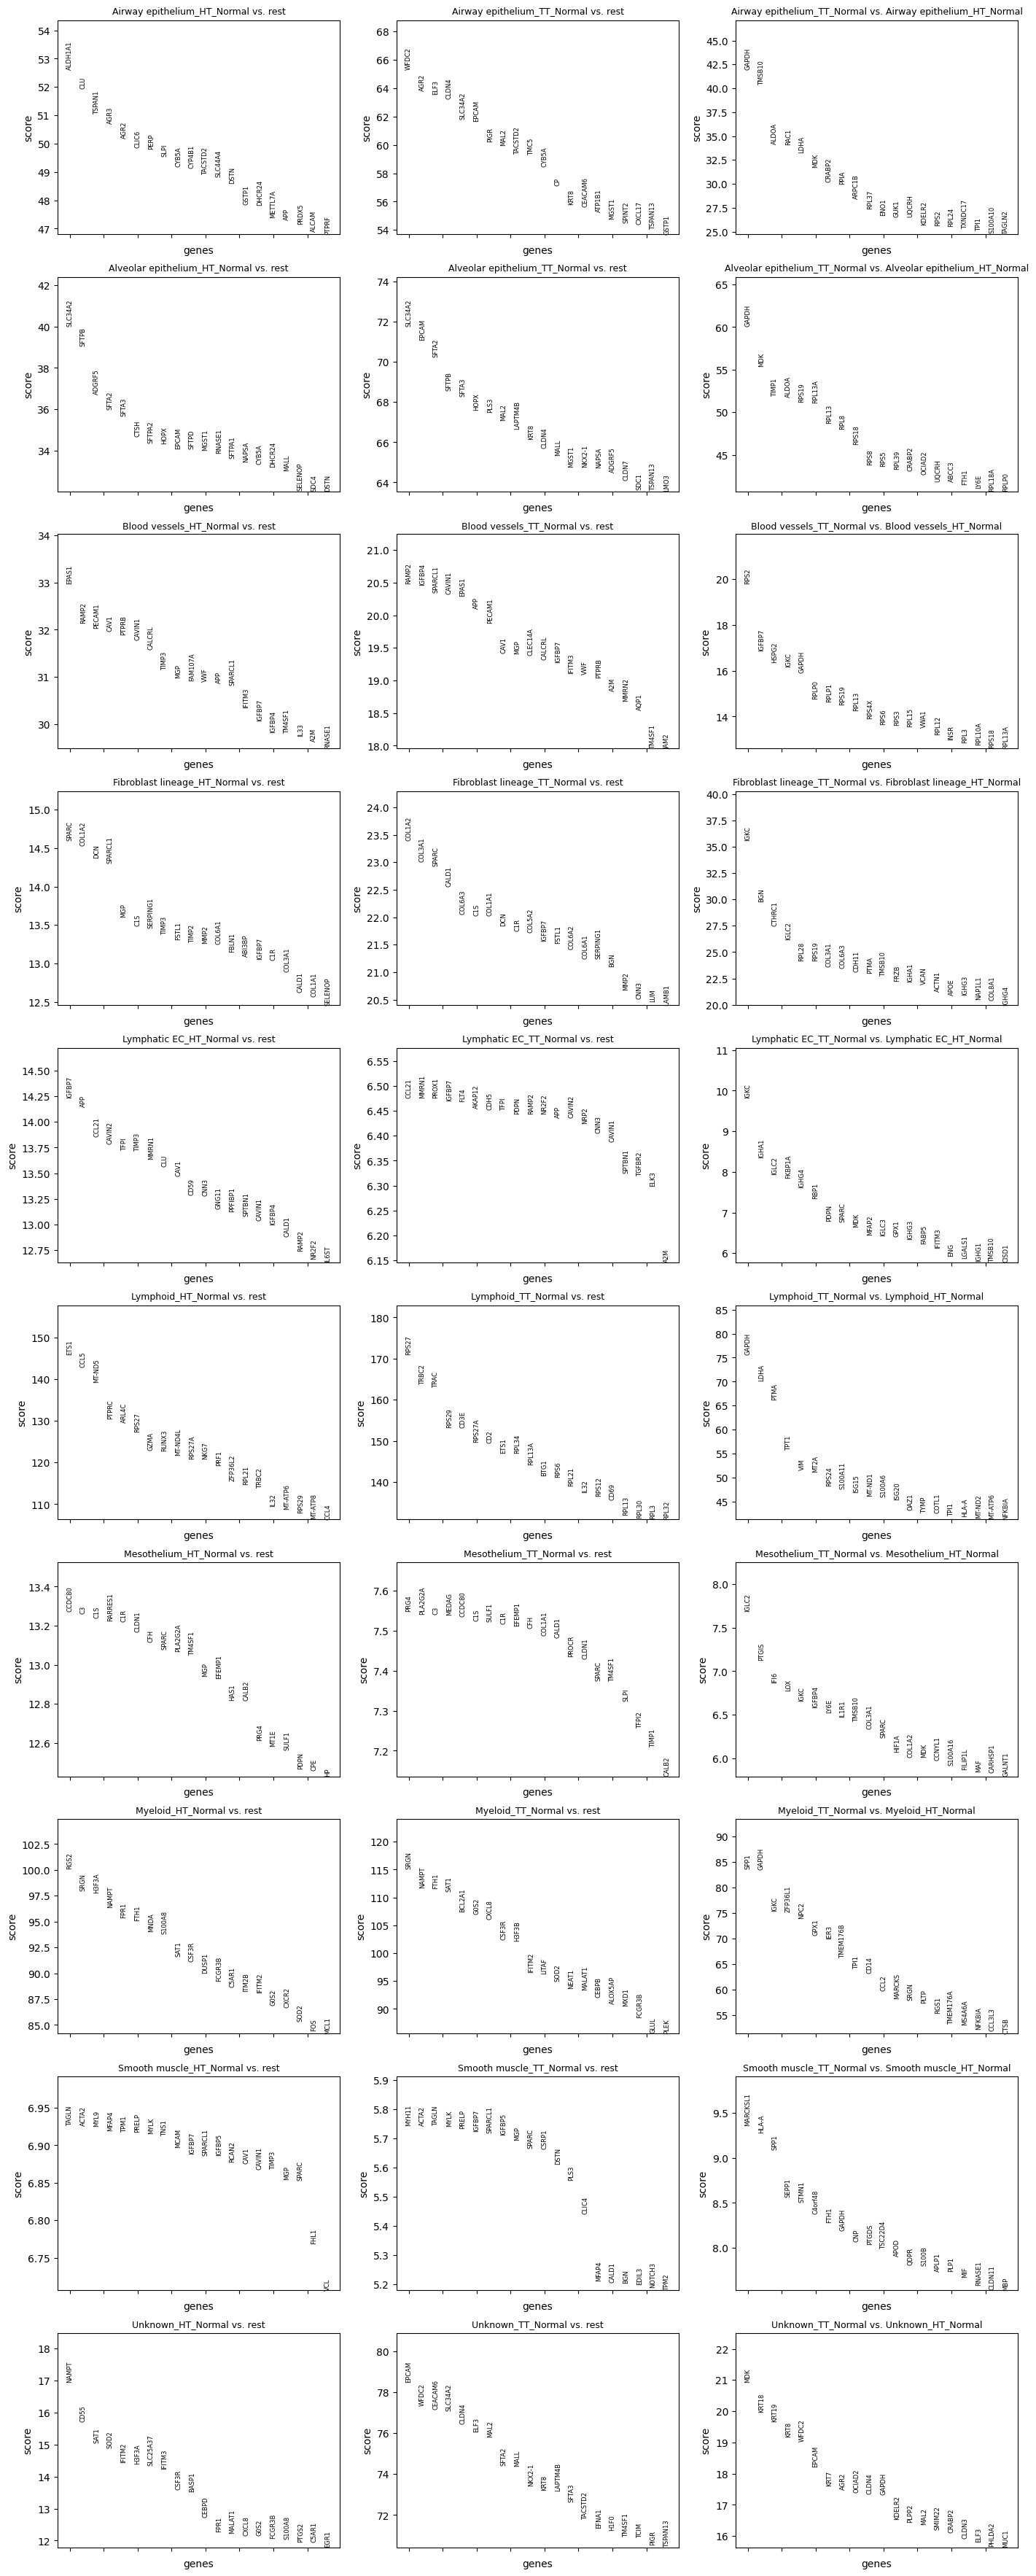

In [24]:
from warnings import warn

if(adata.obs.origin.str.contains('normal').any()):
    fig, axs = plt.subplots(num_types, 3, figsize=(17, 4.5*num_types))
    n_genes = 20
    for i, type in enumerate(types):
        normal_healthy = type + '_HT_Normal'
        normal_tumor = type + '_TT_Normal'
        titlesize = 9
        fontsize = 6
    
        
        cond_plot(adata, [normal_healthy], valid_types, n_genes=n_genes,
                         ax= axs[i, 0], sharey=False, key="wilcoxon", show=False,
                         fontsize=fontsize, titlesize=titlesize)
        cond_plot(adata, [normal_tumor], valid_types, n_genes=n_genes,
                                ax= axs[i, 1], sharey=False, key="wilcoxon", show=False,
                         fontsize=fontsize, titlesize=titlesize)
        print(f"w_pair_{type}_normal")
        cond_plot(adata, [normal_tumor, normal_healthy], valid_types, n_genes=n_genes, ax= axs[i, 2],
                                key=f"w_pair_{type}_normal", show=False,
                         fontsize=fontsize, titlesize=titlesize)
    
    # Display the entire figure with all plots
    plt.show()
else:
    warn('No healthy tissue!')
    

## Heatmaps

         Falling back to preprocessing with `sc.pp.pca` and default params.


/usr/local/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:1067: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if isinstance(groupby, str) and is_categorical_dtype(adata.obs[groupby]):
/usr/local/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[group]):
/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


categories: Airway epithelium_HT_Normal, Airway epithelium_HT_Tumor, Airway epithelium_TT_Normal, etc.
var_group_labels: Lymphoid_TT_Normal, Lymphoid_HT_Normal, Myeloid_HT_Tumor, etc.


/usr/local/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


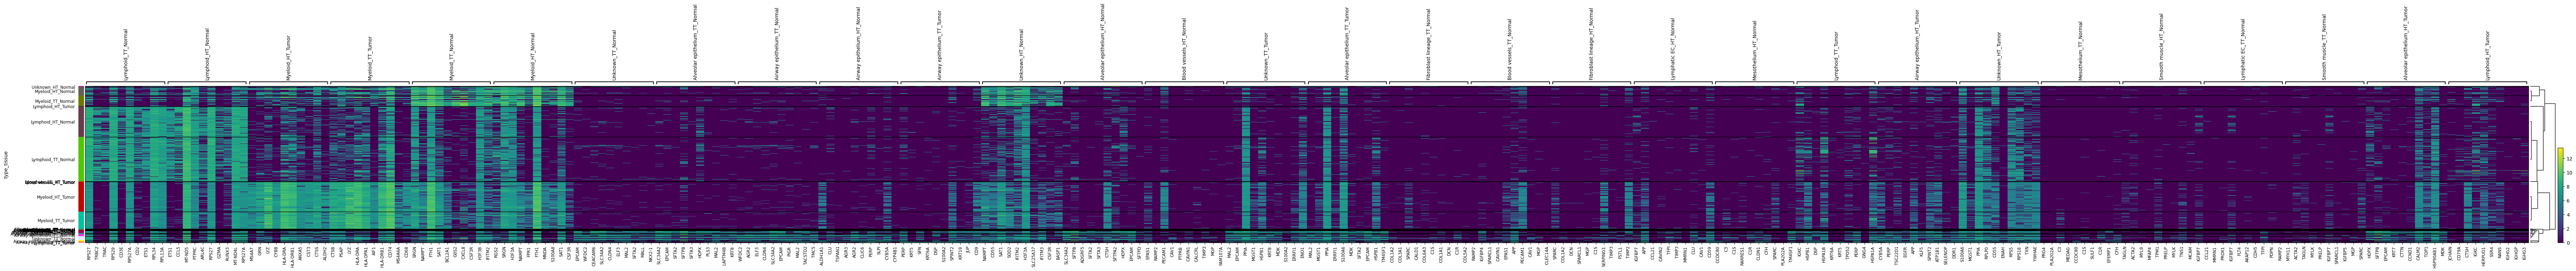

In [25]:
sc.pl.rank_genes_groups_heatmap(adata, show_gene_labels=True, key='wilcoxon')

## GSEA

In [26]:
from gprofiler import GProfiler
import gseapy
import seaborn as sns
gp = GProfiler(return_dataframe=True, user_agent='INMEGEN')

In [27]:
# gen_list = adata.uns['wilcoxon']['names']['Airway epithelium_TT_Tumor'][100:]
# enrich = gp.profile(list(gen_list), sources=['GO:BP'], organism="hsapiens")
# enrich.iloc[:25,:]

In [28]:
#  Download Gene symbols
if not os.path.exists('h.all.v2023.2.Hs.symbols.gmt'):
    ! wget https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.2.Hs/h.all.v2023.2.Hs.symbols.gmt

#  Gene entrez
# if not os.path.exists('h.all.v2023.2.Hs.entrez.gmt'):
# ! wget https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.2.Hs/h.all.v2023.2.Hs.entrez.gmt

In [29]:
valid_types = list(adata.obs['type_tissue'].value_counts().loc[lambda x: x > 2].index)

In [30]:
from typing import List

def get_gseas_df(adata: ad.AnnData, valid_types: List[str], types: List[str], id_: str, load_gsea: bool = False) -> pd.DataFrame:
    """
    Generates a combined DataFrame from GSEA results for different cell types.

    Args:
    adata (ad.AnnData): An AnnData object containing the dataset.
    valid_types (List[str]): A list of valid cell types to filter the cell types.
    types (List[str]): A list of cell types to be considered for analysis.
    id_ (str): Identifier used in generating the GSEA path.
    load_gsea (bool, optional): Flag to load existing GSEA results. Defaults to False.

    Returns:
    pd.DataFrame: A combined DataFrame with GSEA results pivoted by cell type and hallmark.

    The function uses the provided 'types', intersects them with 'valid_types',
    and computes GSEA for each type. The final DataFrame is a pivot table with cell types as rows
    and GSEA hallmarks as columns.
    """
    # Intersect types with valid types
    types = set(types).intersection(valid_types)

    gsea_folder = 'gseapy_gsea'
    dfs = []

    for type in types:
        wilco = adata.uns['wilcoxon']
        gsea_path = f'{gsea_folder}/{type}_{id_}.npz'

        # Generate gene scores
        gene_scores = {gene: wilco['scores'][type][i] for i, gene in enumerate(wilco['names'][type])}
        gene_scores = pd.Series(gene_scores)

        # Run GSEA
        if load_gsea:
            gseas = np.load(gsea_path, allow_pickle='TRUE').item()
        else:
            pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
                                     processes=20, permutation_num=100, seed=6, no_plot=True)
            gseas = pre_res.res2d
            np.save(gsea_path, gseas)

        data1 = {'hallmark': list(gseas['Term'].str.slice(9)), 'score': list(gseas['NES'])}
        df_celltype1 = pd.DataFrame(data1)
        df_celltype1['cell_type'] = type
        dfs.append(df_celltype1)

    # Combine all DataFrames
    combined_df = pd.concat(dfs).reset_index(drop=True).pivot(index='cell_type', columns='hallmark', values='score')
    return combined_df

In [31]:
#papermill_description=GSEA
gsea_folder = 'gseapy_gsea'
gsea_path = f'{gsea_folder}/heatmap_{id_}.csv'

if load_gsea_heatmap:
    combined_df = pd.read_csv(gsea_path, index_col=0)
else:
    types = adata.obs.loc[:, 'type_tissue'].unique()
    combined_df = get_gseas_df(adata, valid_types, types, id_, load_gsea=False)
    combined_df.to_csv(gsea_path)

/tmp/ipykernel_27790/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:34:44,475 [WARNING] Duplicated values found in preranked stats: 20.58% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27790/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:34:45,242 [WARNING] Duplicated values found in preranked stats: 35.44% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27790/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:34:46,191 [WARNING] Duplicated values found in preranked stats: 54.60% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27790/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:34:46,949 [WARNING] Duplicated values found in preranked stats: 46.99% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27790/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:34:47,702 [WARNING] Duplicated values found in preranked stats: 50.09% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27790/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:34:48,424 [WARNING] Duplicated values found in preranked stats: 26.62% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27790/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:34:49,235 [WARNING] Duplicated values found in preranked stats: 57.62% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27790/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:34:49,958 [WARNING] Duplicated values found in preranked stats: 25.57% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27790/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:34:50,717 [WARNING] Duplicated values found in preranked stats: 21.36% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27790/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:34:51,508 [WARNING] Duplicated values found in preranked stats: 46.72% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27790/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:34:52,363 [WARNING] Duplicated values found in preranked stats: 18.51% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27790/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:34:53,119 [WARNING] Duplicated values found in preranked stats: 47.93% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27790/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:34:54,117 [WARNING] Duplicated values found in preranked stats: 23.49% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27790/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:34:55,199 [WARNING] Duplicated values found in preranked stats: 27.69% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27790/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:34:55,978 [WARNING] Duplicated values found in preranked stats: 50.67% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27790/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:34:56,743 [WARNING] Duplicated values found in preranked stats: 51.92% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27790/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:34:57,692 [WARNING] Duplicated values found in preranked stats: 30.50% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27790/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:34:58,456 [WARNING] Duplicated values found in preranked stats: 39.98% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27790/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:34:59,250 [WARNING] Duplicated values found in preranked stats: 26.49% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27790/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:34:59,996 [WARNING] Duplicated values found in preranked stats: 53.92% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27790/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:35:00,758 [WARNING] Duplicated values found in preranked stats: 43.78% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27790/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:35:01,501 [WARNING] Duplicated values found in preranked stats: 26.21% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27790/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:35:02,269 [WARNING] Duplicated values found in preranked stats: 42.74% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27790/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:35:03,045 [WARNING] Duplicated values found in preranked stats: 56.09% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27790/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:35:03,804 [WARNING] Duplicated values found in preranked stats: 51.99% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27790/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:35:04,543 [WARNING] Duplicated values found in preranked stats: 36.06% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27790/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:35:05,283 [WARNING] Duplicated values found in preranked stats: 54.91% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27790/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:35:06,233 [WARNING] Duplicated values found in preranked stats: 47.94% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27790/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:35:07,298 [WARNING] Duplicated values found in preranked stats: 35.71% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27790/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:35:08,096 [WARNING] Duplicated values found in preranked stats: 28.40% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [32]:
combined_df

hallmark,ADIPOGENESIS,ALLOGRAFT_REJECTION,ANDROGEN_RESPONSE,ANGIOGENESIS,APICAL_JUNCTION,APICAL_SURFACE,APOPTOSIS,BILE_ACID_METABOLISM,CHOLESTEROL_HOMEOSTASIS,COAGULATION,...,PROTEIN_SECRETION,REACTIVE_OXYGEN_SPECIES_PATHWAY,SPERMATOGENESIS,TGF_BETA_SIGNALING,TNFA_SIGNALING_VIA_NFKB,UNFOLDED_PROTEIN_RESPONSE,UV_RESPONSE_DN,UV_RESPONSE_UP,WNT_BETA_CATENIN_SIGNALING,XENOBIOTIC_METABOLISM
cell_type,,,,,,,,,,,,,,,,,,,,,
Airway epithelium_HT_Normal,1.072141,-1.000000,1.026640,0.722274,0.674540,0.707156,0.792537,1.223413,1.131841,0.807543,...,1.182961,1.048985,1.214346,0.826181,-1.000000,0.955345,1.138059,0.793014,0.959562,1.114812
Airway epithelium_HT_Tumor,1.038763,-2.173110,1.159137,1.189807,1.074444,0.824788,0.950938,0.984519,1.105661,1.013631,...,1.224030,0.920757,1.216069,1.131605,-1.253200,1.290629,1.413074,0.930015,1.227041,1.175326
Airway epithelium_TT_Normal,1.172509,-1.000000,1.212969,1.044197,0.851217,0.915064,1.013380,1.090894,1.171339,1.100742,...,1.331787,1.204155,1.119913,0.992416,-1.000000,1.331681,1.172214,1.007287,0.874338,1.094750
Airway epithelium_TT_Tumor,1.121287,-1.000000,1.114531,0.866505,0.956923,0.996303,0.966051,0.988630,1.147045,0.789280,...,1.252937,1.126206,1.137539,0.967210,0.684139,1.229135,1.066999,1.055999,1.016982,1.058744
Alveolar epithelium_HT_Normal,1.316363,-1.000000,1.308807,0.906381,0.932471,0.833376,0.950546,1.270161,1.453845,1.244032,...,1.387783,1.040186,1.147299,1.097559,0.826495,1.155352,1.212533,1.127360,0.990872,1.275847
Alveolar epithelium_HT_Tumor,1.037867,-1.000000,1.021635,0.845300,0.951384,0.773144,0.892126,0.946329,1.028942,1.011674,...,1.247195,0.790854,1.201903,1.074289,-1.000000,1.197719,1.031307,0.958429,0.894201,1.013550
Alveolar epithelium_TT_Normal,1.193597,-1.000000,1.109156,0.886730,0.908229,0.856901,0.983663,1.088034,1.156670,1.037985,...,1.297515,1.109458,1.079931,1.050468,0.675988,1.269122,1.057977,1.073261,0.976901,1.105831
Alveolar epithelium_TT_Tumor,1.181262,-1.000000,0.994225,0.750683,0.980083,0.920722,0.877738,1.042197,1.135317,0.989203,...,1.293242,1.099346,1.175889,0.819415,-1.000000,1.327280,0.957721,0.823713,1.039511,1.099876
Blood vessels_HT_Normal,-0.983256,-1.729593,0.923960,1.330035,1.315842,1.080485,1.182131,-1.044039,-0.959744,1.597905,...,-0.845330,-0.960874,-0.714946,1.424015,-1.222479,-1.200665,1.593195,-0.954538,1.155175,-0.890199


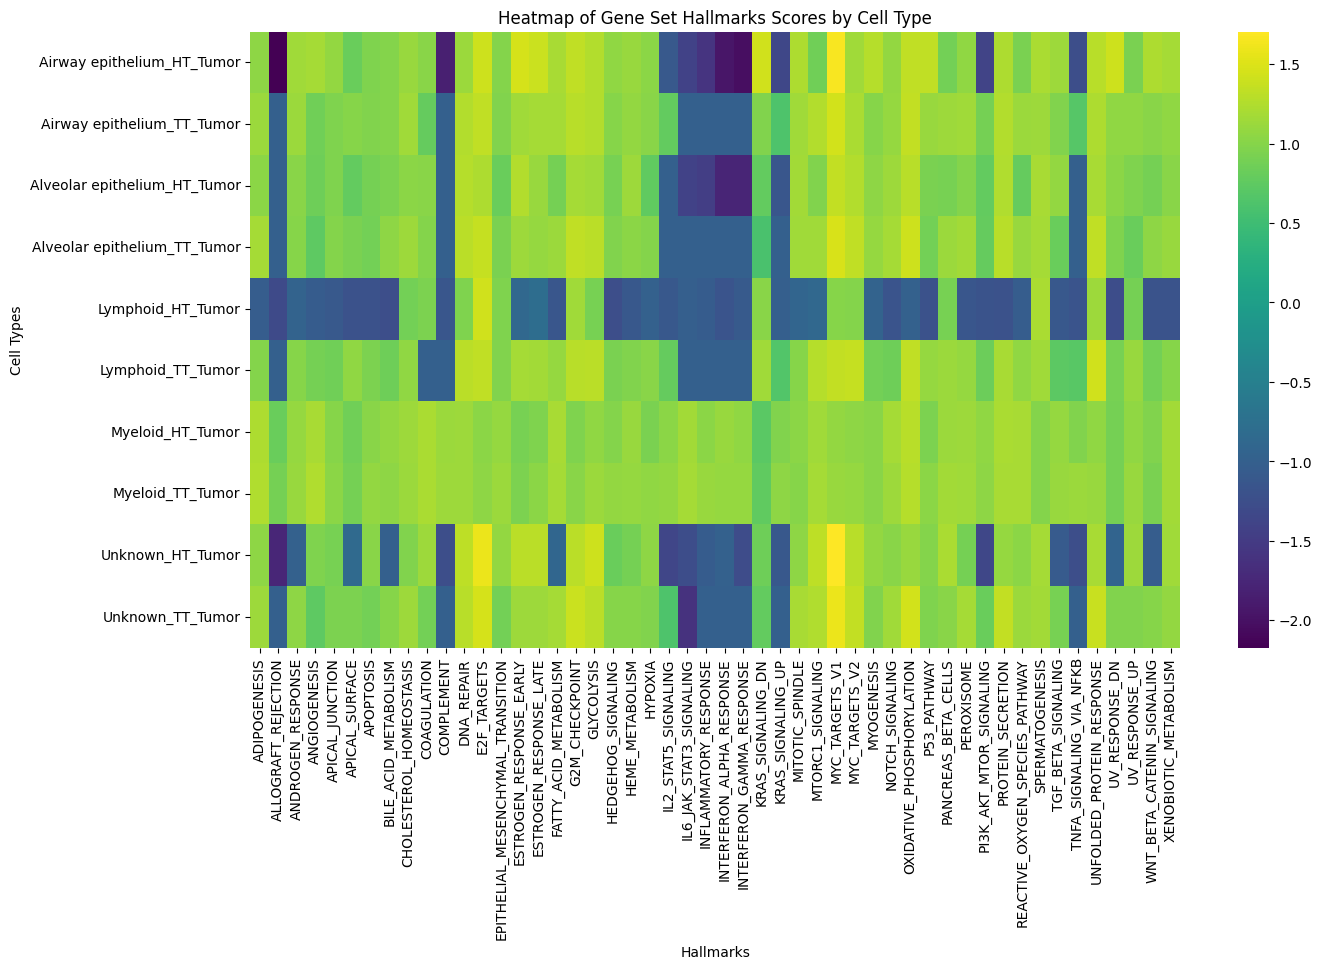

In [33]:
# Plotting the heatmap
combined_df_tumor = combined_df.loc[combined_df.index.str.split('_').str[-1] == 'Tumor']

plt.figure(figsize=(15, 8))
sns.heatmap(combined_df_tumor, cmap='viridis')
plt.title('Heatmap of Gene Set Hallmarks Scores by Cell Type')
plt.xlabel('Hallmarks')
plt.ylabel('Cell Types')
plt.show()

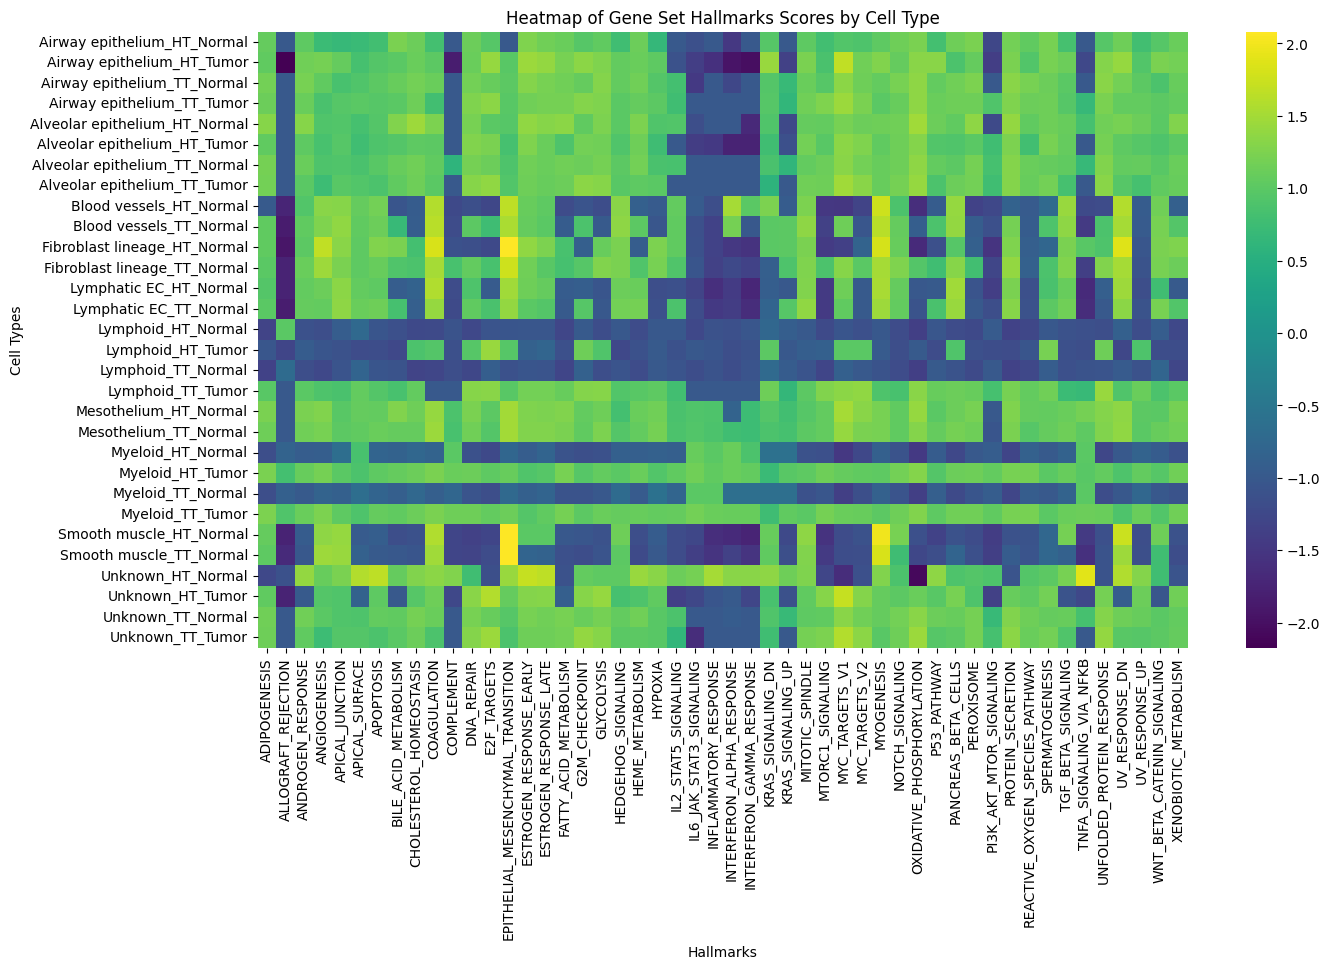

In [34]:
# Plotting the heatmap
combined_df_tumor = combined_df.loc[combined_df.index.str.split('_').str[-1] == 'Normal']

plt.figure(figsize=(15, 8))
sns.heatmap(combined_df, cmap='viridis')
plt.title('Heatmap of Gene Set Hallmarks Scores by Cell Type')
plt.xlabel('Hallmarks')
plt.ylabel('Cell Types')
plt.show()